# Setup

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import glob
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/home/gasia/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

/home/gasia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# StarSpace tsv

In [3]:
word_space_df = pd.read_csv('/home/gasia/StarSpace/words_space_2.tsv', sep='\t', header=None)

In [4]:
word_space_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,__word__price,-0.000046,0.000020,0.000053,-0.000038,-0.000060,0.000009,-0.000039,-0.000006,-0.000042,...,-0.000032,0.000031,-0.000051,-0.000014,2.554380e-05,-0.000034,0.000008,-0.000007,-0.000019,-0.000015
1,__word__go,-0.000098,-0.000015,0.000066,0.000041,-0.000055,0.000055,0.000078,-0.000014,-0.000161,...,-0.000026,0.000228,0.000019,0.000073,6.676970e-05,-0.000016,-0.000054,0.000022,-0.000055,0.000180
2,__word__people,-0.000078,-0.000160,-0.000108,0.000205,-0.000097,0.000110,-0.000079,0.000257,-0.000029,...,0.000118,0.000014,-0.000033,-0.000053,1.014200e-04,-0.000182,0.000055,-0.000004,-0.000053,-0.000093
3,__word__time,-0.000076,-0.000088,0.000041,-0.000022,-0.000075,0.000010,0.000002,-0.000112,-0.000116,...,0.000092,0.000067,0.000062,0.000012,8.405510e-07,-0.000105,-0.000095,-0.000094,-0.000013,-0.000118
4,__word__rise,0.000054,-0.000025,0.000090,-0.000016,-0.000094,0.000046,-0.000133,0.000009,0.000040,...,-0.000098,-0.000082,-0.000100,-0.000076,1.344670e-04,-0.000068,0.000138,-0.000014,0.000037,-0.000115


In [5]:
embedding_matrix = word_space_df.iloc[:,1:].values*100
# np.savetxt('embedding_matrix_2.txt', embedding_matrix)

In [6]:
b = np.loadtxt('embedding_matrix_2.txt', dtype=float)
embedding_matrix == b

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [7]:
embedding_matrix

array([[-0.00456174,  0.00199049,  0.00530094, ..., -0.000747  ,
        -0.00185691, -0.00148372],
       [-0.0098209 , -0.0015483 ,  0.00657379, ...,  0.00215319,
        -0.0055143 ,  0.017991  ],
       [-0.00775015, -0.0160362 , -0.0108018 , ..., -0.00035693,
        -0.00529569, -0.00925997],
       ...,
       [ 0.315015  ,  0.189739  , -0.0696987 , ...,  0.0138445 ,
        -0.295265  , -0.203578  ],
       [ 0.149428  ,  0.208481  , -0.17191   , ..., -0.0259275 ,
        -0.155085  , -0.10129   ],
       [-0.0167871 , -0.0298068 , -0.0422543 , ...,  0.142328  ,
         0.144241  ,  0.294094  ]])

In [8]:
len(embedding_matrix), len(embedding_matrix[0])

(74518, 100)

# Read Data

In [9]:
df = pd.read_csv('final_ready_all_data_word_to_vec_2.csv', parse_dates = (['timestamp'])).set_index('timestamp')
df.sort_index(inplace = True)

In [10]:
word_to_vec_data = df['word_to_vec_id'].values
price_label = df['price_change'].values

In [11]:
import json
word_to_vec_data = [json.loads(elem) for elem in word_to_vec_data]

In [12]:
price_label = price_label*1000

In [13]:
price_label = [-1 if elem <= -1 else elem for elem in price_label ]
price_label = [1 if elem >= 1 else elem for elem in price_label ]

(array([89868., 11345., 14080., 18875., 32849., 37072., 22085., 16630.,
        13124., 95738.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

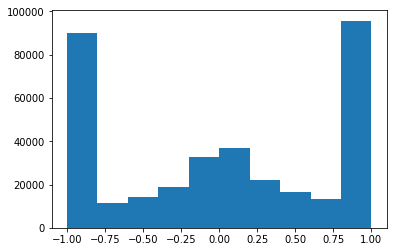

In [14]:
plt.hist(price_label)

# Train/Test

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
emb_len = len( np.loadtxt('embedding_matrix_2.txt', dtype=float))
padded_docs = pad_sequences(word_to_vec_data, maxlen=150, padding='post', value=emb_len)
print(padded_docs)

[[    9   785    56 ... 74518 74518 74518]
 [21275  3616  1197 ... 74518 74518 74518]
 [ 1218    64   648 ... 74518 74518 74518]
 ...
 [  308  3210     4 ... 74518 74518 74518]
 [  284    11    26 ... 74518 74518 74518]
 [  398    64     0 ... 74518 74518 74518]]


In [31]:
# divide to train test validation sets (80% 10% 10%)

s = [t.value // 10 ** 9 for t in df.index]
df['unix'] = s
# additional_data = df[['polarity', 'subjectivity', 'unix', 'topic_id']].values

additional_data = df[['polarity', 'subjectivity']].values
X_train, X_test, y_train, y_test, additional_train, additional_test = train_test_split(padded_docs, price_label, additional_data, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val, additional_train, additional_val = train_test_split(X_train, y_train, additional_train, test_size=0.1, random_state=1)

In [32]:
ll = [len(elem) for elem in padded_docs]

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 351666.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

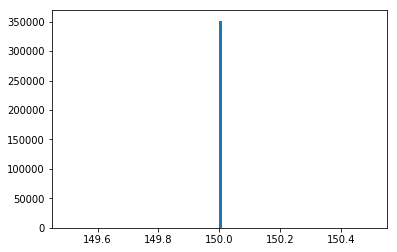

In [33]:
plt.hist(ll, bins = 100)

# Dictionary

In [34]:
word_space_df[0] = [ww[8:] if type(ww) != float else str(ww) for ww in word_space_df[0] ]

In [35]:
words_dict = word_space_df[0].to_dict()

In [36]:
words_dict = dict(zip(words_dict.values(), words_dict.keys()))

In [37]:
# import json 
# with open('word_dict.json', 'w') as outfile:
#     json.dump(words_dict, outfile)

In [38]:
with open('word_dict_2.json') as json_data:
    words_dict_test = json.load(json_data)

----------

# Neural Network LSTM

In [39]:
from keras.layers import Dense, Activation, Embedding, Flatten, Dropout, TimeDistributed, Reshape, Lambda
from keras.layers import LSTM

In [40]:
embedding_matrix = np.loadtxt('embedding_matrix_2.txt', dtype=float)

In [41]:
zero_padding_embedding = (np.zeros(len(embedding_matrix[0]), dtype=float))
embedding_matrix = np.row_stack([embedding_matrix, zero_padding_embedding])

In [42]:
hidden_size = 8 #25
use_dropout=True

-----------

In [44]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate
from keras.models import Model

In [51]:
main_input = Input(shape=(150,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense len(embedding_matrix[0])-dimensional vectors.
x = Embedding(output_dim = len(embedding_matrix[0]), input_dim = len(embedding_matrix),
                    weights=[embedding_matrix], input_length = 150, trainable=False)(main_input)
# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(units = 100)(x)

# model.add(Dense(1, activation='sigmoid'))
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)


In [88]:
auxiliary_input = Input(shape=(2,), name='aux_input')
x = concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top

x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(512, activation='tanh')(x)
x = Dense(2048, activation='tanh')(x)

# And finally we add the main logistic regression layer
main_output = Dense(1, activation='tanh', name='main_output')(x)

In [89]:
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

In [90]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 100)     7451900     main_input[0][0]                 
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100)          80400       embedding_2[0][0]                
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
concatenat

In [91]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
model.fit([np.array(X_train), additional_train], [np.array(y_train)],
          epochs=6, batch_size=32)

In [104]:
len(additional_test[0])

2

In [94]:
loss, accuracy = model.evaluate([X_test, additional_test], np.array(y_test), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 23.900247


In [95]:
loss, accuracy = model.evaluate([X_val, additional_val], np.array(y_val), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 24.154818


In [96]:
loss, accuracy = model.evaluate([X_train, additional_train], np.array(y_train), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 24.135595


In [108]:
from keras.models import model_from_json

#serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Saved model to disk
Loaded model from disk


In [110]:
 
# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
score = loaded_model.evaluate([X_test, additional_test], y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


acc: 23.90%


---------------